In [1]:
# download data from your google drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cp "/gdrive/MyDrive/Fibermagic Tutorial" "." -r

Mounted at /gdrive
/gdrive
cp: cannot create directory './Fibermagic Tutorial': Operation not supported


In [1]:
!pip install fibermagic

## Fiber Photometry using Neurophotometrics devices

There are a bunch of different photometry systems out there like TDT systems, Neurophotometrics or open-hardware approaches. In this tutorial, we will use data from Neurophotometrics as an example.

![grafik.png](attachment:grafik.png)

## Multiple Colors

With Neurophotometrics (NPM), it is possible to capture data from two fluorescent sensors simultaneously - if they emit light in different wave lengths. NPM can measure light of two different color spectra: Red and Green. Using this technology, it is possible, to e.g. express a green calcium sensor (e.g. GCaMP6f) and a red dopamine sensor (e.g. Rdlight1).

![grafik.png](attachment:grafik.png)
grafik source: https://www.researchgate.net/publication/264796291_Bright_and_fast_multi-colored_voltage_reporters_via_electrochromic_FRET/figures?lo=1

# Fibermagic Tutorial

Fibermagic is an open-source software package for the analysis of photometry data. It is written in Python and operates on pandas and numpy dataframes.

Fiber Photometry is a novel technique to capture neural activity in-vivo with a subsecond temporal precision. Genetically encoded fluorescent sensors are expressed by either transfection with an (AAV)-virus or transgenic expression. Strenght of fluorescence is dependent on the concentration of the neurotransmitter the sensor detects. Using an optic glas fiber, it is possible to image neural dynamics and transmitter release.

![grafik.png](attachment:grafik.png)
graphik source: https://en.wikipedia.org/wiki/Fiber_photometry

## Multiple Mice

NPM can record data from multiple mice at once - delivered through a single path chord that splits into several small cables that can be attached individually to a single mouse.

The end of the patch chord projects to a photosensor which captures the light. Here's how it looks like:

![grafik.png](attachment:grafik.png)

Before starting the recording, the researcher defines a region of interest for each cable and color. Then, NPM captures the light intensity for each region of interest seperately. All data streams are written into one single csv file per recording.

## Investigating a single raw data file

Let's have a look into an arbitrary recording file and try to understand the data.

In [53]:
#!pip install pandas
import pandas as pd

In [84]:
df = pd.read_csv('B4923/FP.csv')
df.head(10)

FrameCounter  SystemTimestamp  LedState  ComputerTimestamp  Region0R  \
0             0      4313.569568         7        79933016.54  0.003869   
1             1      4313.632032         4        79933076.54  0.036802   
2             2      4313.694528         1        79933136.55  0.024157   
3             3      4313.757024         0        79933206.54  0.003869   
4             4      4313.819552         0        79933266.55  0.003869   
5             5      4313.882016         0        79933326.55  0.003869   
6             6      4313.944544         0        79933386.55  0.003869   
7             7      4314.007040         0        79933456.54  0.003869   
8             8      4314.069536         0        79933516.56  0.003869   
9             9      4314.132032         0        79933576.56  0.003869   

   Region1G  
0  0.003922  
1  0.634298  
2  0.019896  
3  0.003922  
4  0.003922  
5  0.003922  
6  0.003922  
7  0.003922  
8  0.003922  
9  0.003922

Each Region of Interest is represented as one column. 

A simple frame counter and a timestamp indicate when a measurement happened.

The Flags column encodes different things: Which LED was on at the time of measurement, which input and/or output channel was on or off and whether the laser for optogenetic stimulation was on. NPM encodes all this information into a single number using a dual encoding.

Because the emission spectra of fluorescent proteins are partly overlapping, it is not possible to measure both, the red and green sensor, at the same time. Instead, only one LED is on at a time. That way, we get presice measurements.

![grafik.png](attachment:grafik.png)

We can use fibermagic to decode which LEDs were on at what measurement from the Flags column.

In [85]:
#!pip install fibermagic
from fibermagic.IO.NeurophotometricsIO import extract_leds

In [86]:
if 'Flags' in df.columns:  # legacy fix: Flags were renamed to LedState
    df = df.rename(columns={'Flags': 'LedState'})
df = extract_leds(df).dropna()
df.tail(10)

FrameCounter  SystemTimestamp  LedState  ComputerTimestamp  Region0R  \
16321         16321      5333.632192         4        80953064.20  0.036349   
16322         16322      5333.694688         1        80953124.20  0.021709   
16337         16337      5334.632192         4        80954064.21  0.036567   
16338         16338      5334.694688         1        80954124.21  0.021703   
16353         16353      5335.632192         4        80955066.47  0.036606   
16354         16354      5335.694688         1        80955126.47  0.021733   
16369         16369      5336.632224         4        80956066.50  0.036570   
16370         16370      5336.694720         1        80956126.49  0.021630   
16385         16385      5337.632224         4        80957066.50  0.036859   
16386         16386      5337.694720         1        80957126.52  0.021701   

       Region1G  wave_len  
16321  0.628645     560.0  
16322  0.016551     410.0  
16337  0.628612     560.0  
16338  0.016518     410.0  
16353  0.628587     560.0  
16354  0.016560     410.0  
16369  0.628600     560.0  
16370  0.016508     410.0  
16385  0.628769     560.0  
16386  0.016509     410.0

Now, we have all we need to plot the full trace of a single sensor of one mouse and inspect the raw data values. In this recording, Rdlight1 and GCaMP6f were expressed. Rdlight1 is excited by the 560 nm LED and emits light in the red color spectrum. GCaMP6f is excited by the 470 nm LED and emits light in the green spectrum. Now, let's spike into the raw data of Rdlight1 of a single mouse.

We use "plotly" for plotting here. Plotly is a plotting library for Python and other programming languages. It is interactive, which means we can zoom in and out and scroll through the data, which is exactly what we want to do at the moment.

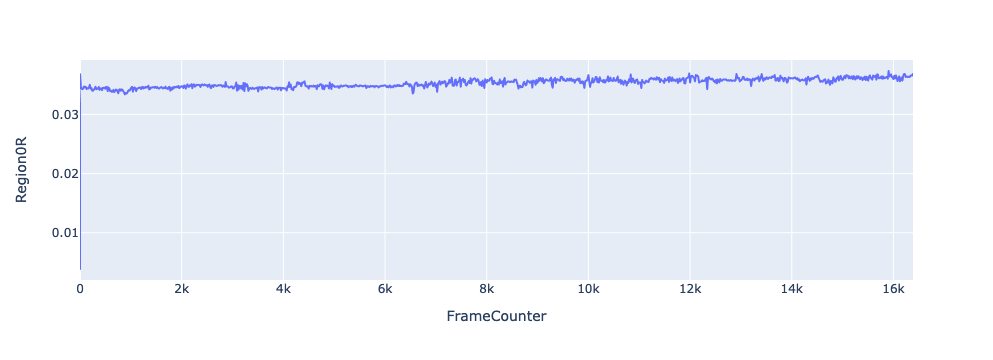

In [87]:
import plotly.express as px
region0R_red = df[df.wave_len == 560][['FrameCounter', 'Region0R']]
px.line(region0R_red, x='FrameCounter', y='Region0R')

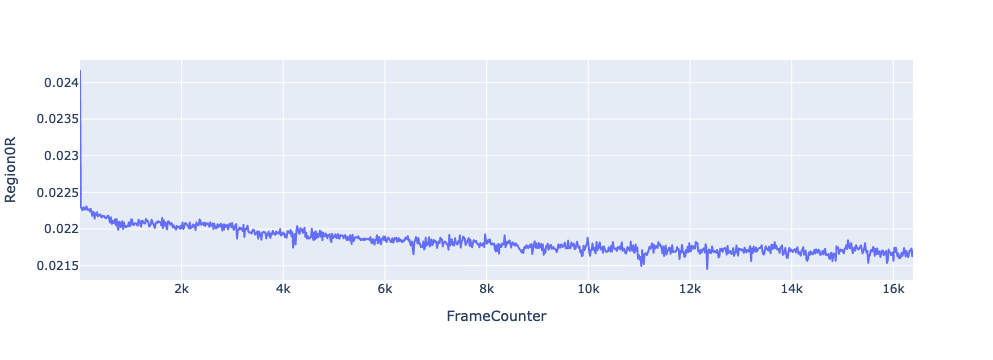

In [88]:
region0R_iso = df[df.wave_len == 410][['FrameCounter', 'Region0R']]
px.line(region0R_iso, x='FrameCounter', y='Region0R')

In [79]:
import numpy as np
referenceR=region0R_iso.Region0R.to_numpy()
#region0R_red.drop(region0R_red.head(1).index, inplace=True)
region0R_red.drop(region0R_red.tail(1).index, inplace=True)
signalR=region0R_red.Region0R.to_numpy()
z_referenceR = (referenceR - np.median(referenceR)) / np.std(referenceR)
z_signalR = (signalR - np.median(signalR)) / np.std(signalR)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning:

Mean of empty slice.

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning:

invalid value encountered in double_scalars

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning:

Degrees of freedom <= 0 for slice

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in true_divide

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning:

invalid value encountered in double_scalars



In [80]:
from sklearn.linear_model import Lasso
lin = Lasso(alpha=0.0001,precompute=True,max_iter=1000,
            positive=True, random_state=9999, selection='random')
n = len(z_referenceR)
lin.fit(z_referenceR.reshape(n,1), z_signalR.reshape(n,1))

ValueError: cannot reshape array of size 0 into shape (933,1)

ValueError: x and y must have same first dimension, but have shapes (933,) and (0,)

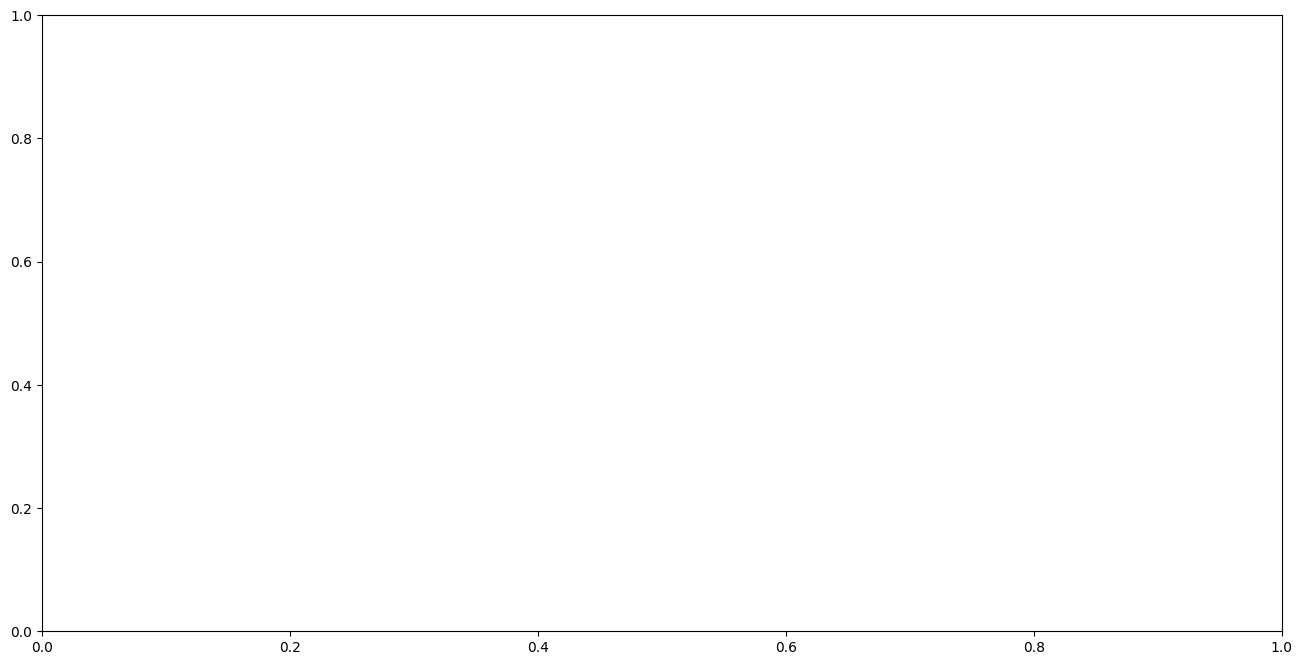

In [81]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(111)
ax1.plot(z_referenceR,z_signalR,'b.')
z_referenceR_fitted = lin.predict(z_referenceR.reshape(n,1)).reshape(n,)
#ax1.set_xlim(-5,5)
ax1.set_ylim(-4,5)
ax1.plot(z_referenceR,z_referenceR_fitted, 'r--',linewidth=1.5)

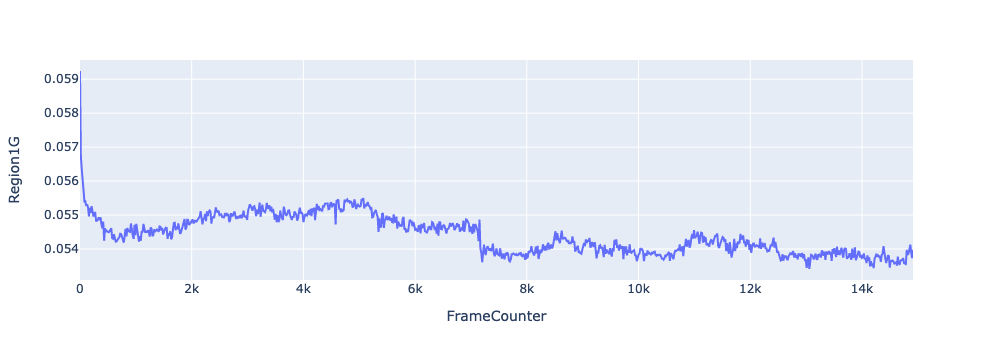

In [82]:
region1G_green = df[df.wave_len == 470][['FrameCounter', 'Region1G']]
px.line(region1G_green, x='FrameCounter', y='Region1G')

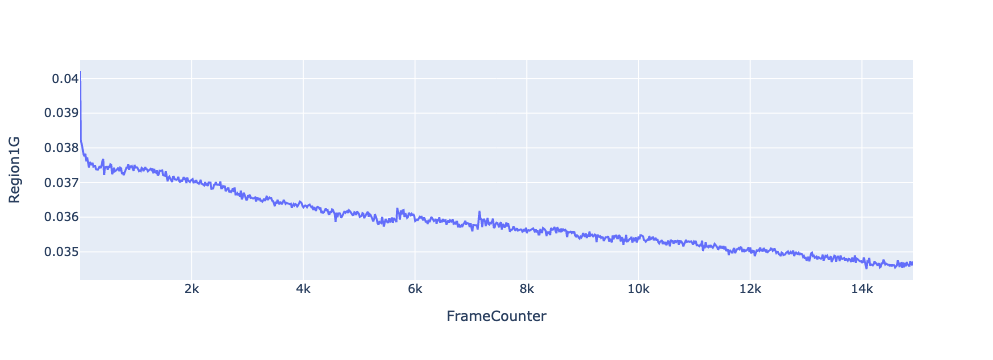

In [83]:
region1G_iso = df[df.wave_len == 410][['FrameCounter', 'Region1G']]
px.line(region1G_iso, x='FrameCounter', y='Region1G')

In [22]:
region1G_iso.drop(region1G_iso.tail(1).index, inplace=True)
referenceG=region1G_iso.Region1G.to_numpy()
region1G_green.drop(region1G_green.tail(1).index, inplace=True)
signalG=region1G_green.Region1G.to_numpy()
z_referenceG = (referenceG - np.median(referenceG)) / np.std(referenceG)
z_signalG = (signalG - np.median(signalG)) / np.std(signalG)

In [23]:
from sklearn.linear_model import Lasso
lin = Lasso(alpha=0.0001,precompute=True,max_iter=1000,
            positive=True, random_state=9999, selection='random')
n = len(z_referenceG)
lin.fit(z_referenceG.reshape(n,1), z_signalG.reshape(n,1))

Lasso(alpha=0.0001, positive=True, precompute=True, random_state=9999,
      selection='random')

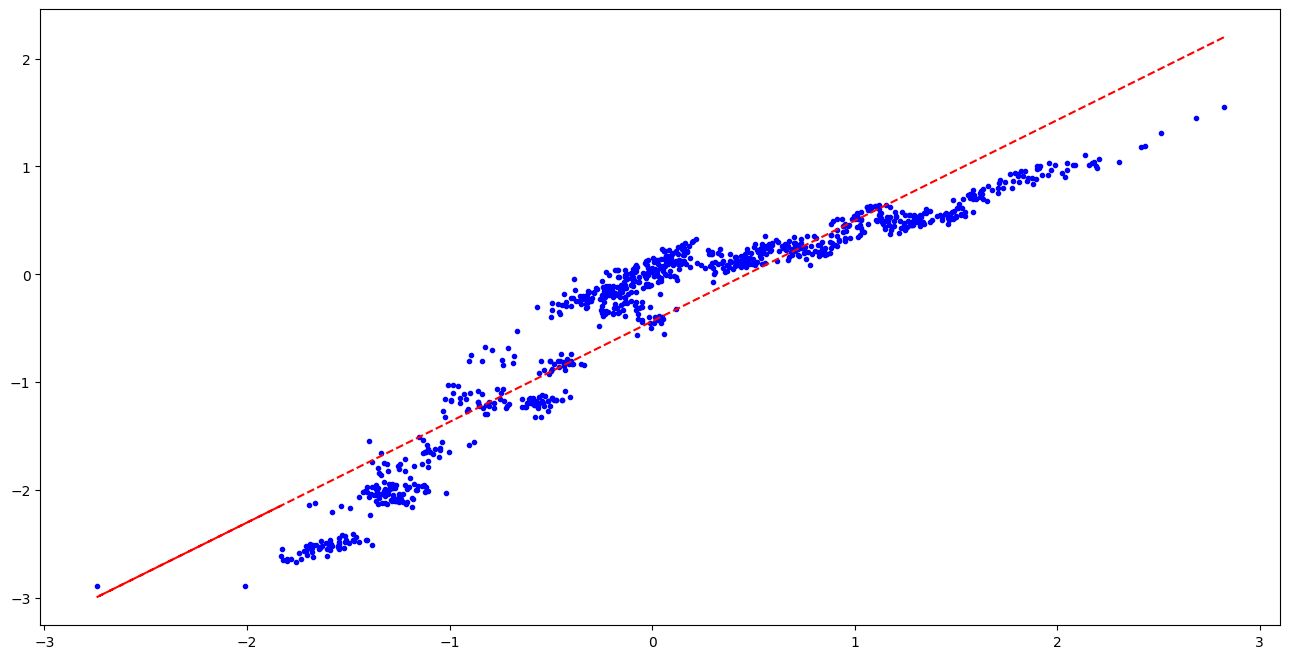

In [24]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(111)
ax1.plot(z_referenceG,z_signalG,'b.')
z_referenceG_fitted = lin.predict(z_referenceG.reshape(n,1)).reshape(n,)
ax1.plot(z_referenceG,z_referenceG_fitted, 'r--',linewidth=1.5)
#ax1.set_xlim(-2,13)
#ax1.set_ylim(-5,10)

###### import plotly.express as px

We can clearly see huge transients from dopamine activity in the raw data. Congratulations!

However, there are several issues with the data. Fiber Photometry is not measureing the difference between day and night. Changes in fluorescence are usually extremely small and very hard to measure. We basically measure light intensity with a super high precision. However, this means that the photometry system will also pick up every disturbance, even if very small.

Examples of unwanted noise are:
* Photobleaching of the Patch Chord
* Photobleaching caused by LED heating
* Photobleaching caused by destroyment of sensors
* Motion artifacts
* Loose or poorly attached cables

![grafik.png](attachment:grafik.png)

## Demodulation of Fiber Photometry Data

As we saw, the raw data is useless without further processing. There are a variety of different of different methods to remove photobleaching and motion artifacts, here are a few examples:

### Correction of Photobleaching:

* High-Pass Filtering: Photobleaching usually occurs at a very slow timescale. By applying a simple high-pass filter, e.g. a butterworth, it is possible to remove the gross artifacts of photobleaching, but it removes also slow changes in neurotransmitter concentration
* Biexponential decay: Photobleaching can be estimated by a decreasing exponential function. However, as it happens on two different timescales (e.g. fast LED-heating-based photobleaching and slow patch chord photobleaching), we need a biexponential decay that can be regressed to the data and then subtracted.
* airPLS: Adaptive iteratively reweighted penalized least squares. A more advanced method to remove artifacts. For more info, please see the paper: DOI: 10.1039/b922045c

### Correction of Motion Artifacts:

* Genetically encoded Neurotransmitter indicators have usually a useful attribute: If stimulated at around 410 nm (instead of e.g. 470 or 560), the excitation will be the same independent of the neurotransmitter concentration. Stimulating a this wave length is called recording an "isobestic". The isobestic is usefull to correct motion artifacts.
* If a transient is caused by neural activity, it should be detectable in the signal channel, but if it is caused by motion, it should be detectable in both, the isobestic and signal.
* We can remove motion artifacts if we fit the isobestic to the signal and subtract.

## Demodulate using airPLS

We can use fibermagic to calculate z-scores of dF/F using the airPLS algorithm. However, before we do that, we need to bring the dataframe into long-format.

In [63]:
NPM_RED = 560
NPM_GREEN = 470
NPM_ISO = 410
# dirty hack to come around dropped frames until we find better solution -
# it makes about 0.16 s difference
df.FrameCounter = df.index // len(df.wave_len.unique())
df = df.set_index('FrameCounter')
regions = [column for column in df.columns if 'Region' in column]
dfs = list()
for region in regions:
    channel = NPM_GREEN if 'G' in region else NPM_RED
    sdf = pd.DataFrame(data={
        'Region': region,
        'Channel': channel,
        'Signal': df[region][df.wave_len == channel],
        'Reference': df[region][df.wave_len == NPM_ISO]
    }
    )
    dfs.append(sdf)
dfs = pd.concat(dfs).reset_index().set_index(['Region', 'Channel', 'FrameCounter'])
dfs

ValueError: cannot reindex from a duplicate axis

In [26]:
from fibermagic.core.demodulate import add_zdFF

dfs = add_zdFF(dfs, method='airPLS', remove=250)

ValueError: zero-size array to reduction operation maximum which has no identity

In [27]:
dfs

Signal  Reference
Region   Channel FrameCounter                     
Region0R 560     0             0.003869   0.021525
                 6                  NaN   0.021509
                 11                 NaN   0.021430
                 16                 NaN   0.021466
                 22                 NaN   0.021478
...                                 ...        ...
Region1G 470     4864          0.024067   0.015788
                 4869          0.024170        NaN
                 4870               NaN   0.015771
                 4875          0.024110   0.015766
                 4880          0.024190   0.015857

[2137 rows x 2 columns]

In [28]:
px.line(dfs.reset_index(), x='FrameCounter', y='zdFF (airPLS)', facet_row='Region')

ValueError: Value of 'y' is not the name of a column in 'data_frame'. Expected one of ['Region', 'Channel', 'FrameCounter', 'Signal', 'Reference'] but received: zdFF (airPLS)

## Analyzing and Synchronizing Behavioral Data

In almost all experiments, we want to collect behavioral data along with the neural data. We then want to correlate the mice's behavior with our neural recording. For example, the mouse might perform a lever pressing task in an operand box. The operand box collects data about the time when the lever is pressed and when a food reward is delivered.

Let's have a look into the log file produced by the operant box

In [239]:
logs = pd.read_csv('operand_box.log')
logs

FileNotFoundError: [Errno 2] No such file or directory: 'operand_box.log'

As we see, the column "SI@0.0" records the type of event (e.g. left lever pressed; food delivered, etc...) and the time.

There are a variety of possibilities how to synchronize the logs with the FP data. In this case, an external generator generates a TTL pulse every 100 ms. The TTL pulse is captured by the operand box and logged as SI. The TTL pulse is also captured by the "input1" channel of NPM and saved in "input1.csv".

Luckily, fibermagic offers functionality to synchronize both.

In [619]:
from fibermagic.IO.NeurophotometricsIO import sync_from_TTL_gen
from pathlib import Path

logs = sync_from_TTL_gen(logs, Path('.'))
logs

NameError: name 'logs' is not defined

We see that the column 'FrameCounter' was added to the dataframe. Now we know exactly where in the photometry data an event happened.

## Plot Perievents

With the synchronization done, we can finally extract a few seconds before and after each event and investigate if there is a common pattern. This is called calculating perievents.

In [584]:
logs['Region'] = 'Region6R'
logs = logs.set_index('Region', append=True).swaplevel()
logs

NameError: name 'logs' is not defined

In [585]:
from fibermagic.core.perievents import perievents

peri = perievents(dfs.set_index('FrameCounter', append=True), logs[logs.Event=='FD'], window=5, frequency=25)
peri

NameError: name 'logs' is not defined

In [586]:
fig = px.scatter(peri.reset_index(), x='Timestamp', y='Trial', color='zdFF (airPLS)', range_color=(-5,5),
                 color_continuous_scale=['blue', 'grey', 'red'], height=250).update_yaxes(autorange="reversed")
for scatter in fig.data:
    scatter.marker.symbol = 'square'
fig.show()

NameError: name 'peri' is not defined

# How to analyze big projects

So far, we analyzed one single mouse, one single recording, one single channel. However, in practice, we usually record from 10-20 mice per experiment and have multiple long recordings. This adds up easily to several hundret files together with all the logs produced. It would be very time consuming and error-prone if a researcher would have to analyze every single file on its own.

Fortunately, fibermagic offers functionality to process a full project at once and fully automatically. In addition, fibermagic is very fast and can process full projects within seconds. Ultimately, you can use the same functions, no matter if you load a full project or a single file.

The only thing you have to do is to structure your project into a tree of directories with one category per level. For example, you may want to structure your project into experimental group (condition/control), experimental procedure (e.g. PR2, PR5, PR8, PR11) and recording (e.g. R1, R2, R3). You have to organize your recordings into subdirectories.
```
== condition
      =PR2
          =R1
               data.csv
               input1.csv
               regions_to_mouse.csv
               time.csv
               logs.csv
          =R2
          =R3
      =PR5
      =PR8
      =PR11
 = control
```


In [ ]:
from fibermagic.IO.NeurophotometricsIO import read_project_logs, read_project_rawdata

help(read_project_rawdata)
help(read_project_logs)

Help on function read_project_rawdata in module fibermagic.IO.NeurophotometricsIO:

read_project_rawdata(project_path, subdirs, data_file, ignore_dirs=['meta'])
    Runs standard zdFF processing pipeline on every trial, mouse and sensor and puts data together in a single df
    :param ignore_dirs: array of directories to exclude from reading
    :param subdirs: array with description of subdirectories to be a column
    :param project_path: root path of the project
    :param data_file: name of each file containing raw data
    :return: dataframe with the following multicolumn/index structure
                            Signal      Reference
    Trial 1 mouse A 560     0.1         0.5
                    560     0.25        0.56
                    470     0.13        0.57
            mouse B 560    ...         ...
    Trial 2 mouse A 470    ...
            mouse B 560
    ...     ...

Help on function read_project_logs in module fibermagic.IO.NeurophotometricsIO:

read_project_logs(pr

In [ ]:
project_path = Path(r'fdrd2xadora_PR_Pilot')
logs = read_project_logs(project_path,
                                 ['Paradigm'], ignore_dirs=['meta', 'processed'])
df = read_project_rawdata(project_path,
                          ['Paradigm'], 'FED3.csv', ignore_dirs=['meta', 'processed'])
df = add_zdFF(df, smooth_win=10, remove=200).set_index('FrameCounter', append=True)
peri = perievents(df, logs[logs.Event == 'FD'], 5, 25)
output_path = project_path / 'processed'
df.to_csv(output_path / 'datastream.csv')
logs.to_csv(output_path / 'logs.csv')
peri.to_csv(output_path / 'perievents.csv')

fdrd2xadora_PR_Pilot\PR2\FED3.csv
fdrd2xadora_PR_Pilot\PR5\FED3.csv
fdrd2xadora_PR_Pilot\PR8\FED3.csv


c:\users\georg\git\fibermagic\fibermagic\core\perievents.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Georg\anaconda3\envs\fibermagic\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\georg\git\fibermagic\fibermagic\core\perievents.py:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

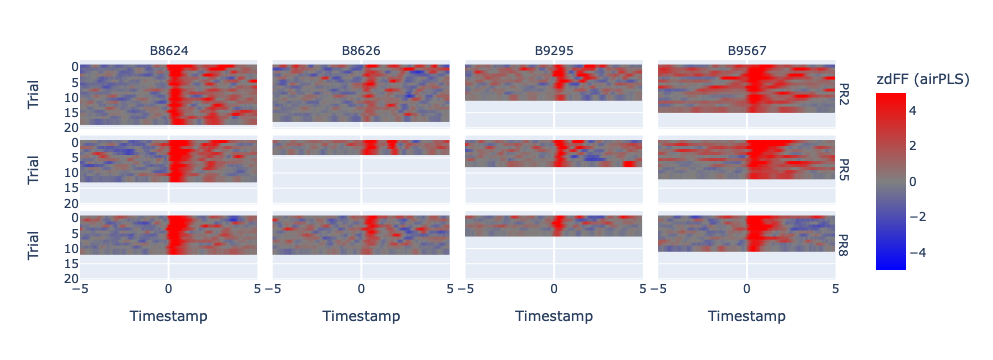

In [ ]:
peri = peri.reset_index()
fig = px.scatter(peri[peri.Channel==560], x='Timestamp', y='Trial', color='zdFF (airPLS)', facet_row='Paradigm', facet_col='Mouse',
          range_color=(-5,5), facet_row_spacing=0, facet_col_spacing=0, width=140*len(peri.Mouse.unique()),
                 color_continuous_scale=['blue', 'grey', 'red']).update_yaxes(autorange="reversed")
for scatter in fig.data:
    scatter.marker.symbol = 'square'
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_xaxes(range = [peri.Timestamp.min(),peri.Timestamp.max()])
fig.update_xaxes(matches='x')
fig.show()

In [ ]:
peri

Signal  Reference  \
Paradigm Mouse Channel Event Timestamp Trial                        
PR2      B8624 470     FD    -5.00     0      0.006799   0.012534   
                             -4.96     0      0.006784   0.012522   
                             -4.92     0      0.006855   0.012628   
                             -4.88     0      0.006739   0.012434   
                             -4.84     0      0.006823   0.012556   
...                                                ...        ...   
PR8      B9567 560     FD     4.84     10     0.014573   0.015935   
                              4.88     10     0.014585   0.016042   
                              4.92     10     0.014531   0.016007   
                              4.96     10     0.014550   0.015916   
                              5.00     10     0.014518   0.015995   

                                              zdFF (airPLS)  
Paradigm Mouse Channel Event Timestamp Trial                 
PR2      B8624 470     FD    -5.00     0           1.204590  
                             -4.96     0           0.873160  
                             -4.92     0           0.765235  
                             -4.88     0           0.468741  
                             -4.84     0           0.503903  
...                                                     ...  
PR8      B9567 560     FD     4.84     10          0.216989  
                              4.88     10          0.065937  
                              4.92     10         -0.016742  
                              4.96     10         -0.066838  
                              5.00     10          0.227642  

[70782 rows x 3 columns]